<a href="https://colab.research.google.com/github/gangishettysoni/project-ml/blob/main/celebal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Step 1: Imports & Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Load Data
train = pd.read_parquet("train.parquet")
test = pd.read_parquet("test.parquet")
sample_submission = pd.read_parquet("sample_submission.parquet")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
train.head()

Train shape: (1639424, 7)
Test shape: (409856, 7)


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


In [15]:
import warnings
warnings.filterwarnings('ignore')

train.info() shows dataset structure (columns, data types, non-null counts) and memory usage.

while train.describe() provides statistical summaries (mean, min, max, quartiles) for numerical columns.

sns.countplot() visualizes the target class distribution to check for imbalance, helping assess if techniques like resampling are needed for modeling.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB
None
                                Date            X1            X2  \
count                        1639424  1.639424e+06  1.639424e+06   
mean   2022-12-03 07:23:43.817145600  1.139258e+00  5.488189e+00   
min              2020-12-16 00:00:00  1.000000e+00  5.412539e+00   
25%              2021-12-10 00:00:00  1.049171e+00  5.480597e+00   
50%              2022-11-30 00:00:00  1.105171e+00  5.488

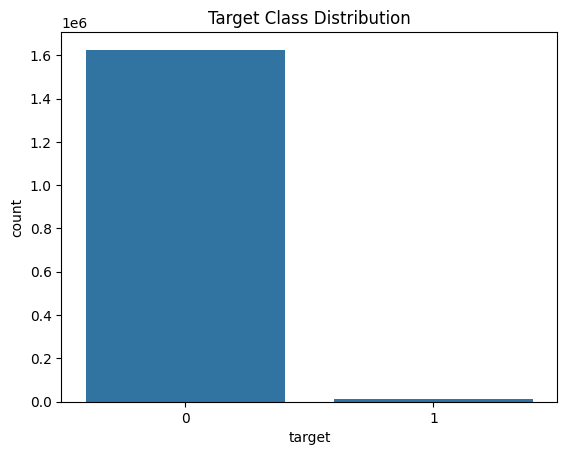

In [16]:
#Step 2: Basic EDA
print(train.info())
print(train.describe())

# Check class balance
sns.countplot(x='target', data=train)
plt.title("Target Class Distribution")
plt.show()

**Feature Engineering**



1)Data Preparation Steps: First, the code converts text categories into numbers (but leaves the target variable alone), removes unnecessary columns like dates and IDs, and then splits the data into training and validation sets while keeping the same class balance. Finally, it adjusts all the numbers to a common scale so no single feature dominates just because it's bigger.

2)Keeping Things Consistent: It carefully makes sure the test data gets treated exactly the same way as the training data - same columns removed, same category numbering, same scaling - to avoid problems when the model makes predictions on new data.

In [17]:
#Step 3: Feature Engineering

# Encode categorical features
# Get all object type columns except 'target' if it's an object type
cat_cols = train.select_dtypes(include='object').columns
if 'target' in cat_cols:
    cat_cols = cat_cols.drop('target')

for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

# Separate features and labels
X = train.drop(['target', 'Date'], axis=1)  # Drop both target and Date columns
y = train['target']

# Make sure test set has same columns as training set
test = test.drop(['Date', 'ID'], axis=1, errors='ignore')  # Drop ID if exists

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test)  # Now test has same features as training

**classical model- Random Forest**

A Random Forest is an ensemble machine learning method that combines multiple decision trees to improve prediction accuracy and reduce overfitting


Model Implementation: This code trains a Random Forest classifier with 200 decision trees (each limited to 15 levels deep) on our preprocessed training data, then evaluates its performance on the validation set using precision/recall metrics.

Key Advantages: Random Forest was chosen for its ability to handle complex patterns while avoiding overfitting (through ensemble voting) and providing feature importance insights, making it a robust baseline model before trying more complex algorithms.

In [18]:
#Step 4: Classical Model - Random Forest

rf = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_val_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    325077
           1       0.90      0.24      0.37      2808

    accuracy                           0.99    327885
   macro avg       0.94      0.62      0.68    327885
weighted avg       0.99      0.99      0.99    327885



# Evaluation for Random Forest
---confusion matrix
---Classification report
---F1-score
---Accuracy











1. Performance Assessment: This code evaluates our model using key metrics - the classification report (precision/recall/F1 for each class), confusion matrix (correct vs incorrect predictions), plus overall F1 score (balance of precision-recall) and accuracy (correct prediction rate).

2. Metric Selection: We use multiple metrics because accuracy alone can be misleading for imbalanced data - F1 score gives better insight into model performance across different classes, while the confusion matrix helps identify specific error patterns

In [29]:
# Evaluation
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1 = f1_score(y_val, y_val_pred, average='weighted')
acc = accuracy_score(y_val, y_val_pred)
print("F1 Score:", f1)
print("Accuracy:", acc)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    325077
           1       0.89      0.23      0.37      2808

    accuracy                           0.99    327885
   macro avg       0.94      0.62      0.68    327885
weighted avg       0.99      0.99      0.99    327885

Confusion Matrix:
 [[324992     85]
 [  2152    656]]
F1 Score: 0.9912015208138137
Accuracy: 0.9931774860088141


Epoch 1/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 112s 3ms/step - accuracy: 0.9916 - loss: 0.0360 - val_accuracy: 0.9923 - val_loss: 0.0308
Epoch 2/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 129s 2ms/step - accuracy: 0.9923 - loss: 0.0319 - val_accuracy: 0.9924 - val_loss: 0.0307
Epoch 3/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 108s 3ms/step - accuracy: 0.9923 - loss: 0.0316 - val_accuracy: 0.9924 - val_loss: 0.0300
Epoch 4/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 100s 2ms/step - accuracy: 0.9923 - loss: 0.0317 - val_accuracy: 0.9925 - val_loss: 0.0302
Epoch 5/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 145s 3ms/step - accuracy: 0.9923 - loss: 0.0313 - val_accuracy: 0.9923 - val_loss: 0.0303
Epoch 6/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 105s 3ms/step - accuracy: 0.9923 - loss: 0.0317 - val_accuracy: 0.9925 - val_loss: 0.0299
Epoch 7/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 104s 3ms/step - accuracy: 0.9924 - loss: 0.0313 - val_accuracy: 0.9925 - val_loss: 0.0308
Epoch 8/50
40986/40986 ━━━━━━━━━━━━━━━━━━━━ 99s 2ms/step - acc

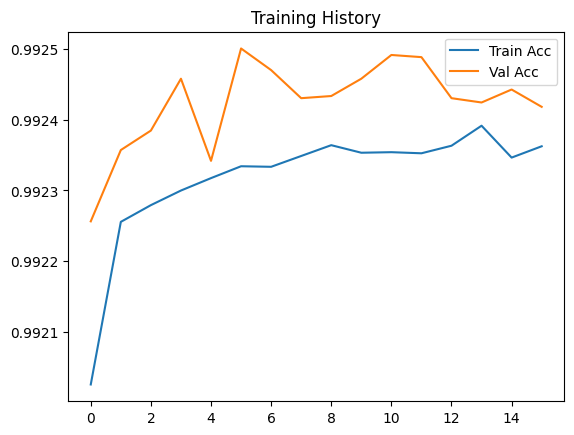

10247/10247 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    325077
           1       0.99      0.12      0.21      2808

    accuracy                           0.99    327885
   macro avg       0.99      0.56      0.60    327885
weighted avg       0.99      0.99      0.99    327885



In [21]:
# 🤖 Step 5: Deep Learning Model

# First ensure y is properly encoded as integers
y_train = y_train.astype(int)
y_val = y_val.astype(int)

# Get number of unique classes
num_classes = len(np.unique(y_train))

model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  # multi-class
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_val_scaled, y_val),
                    epochs=50,
                    batch_size=32,
                    callbacks=[early_stop])

# Plot training history
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training History")
plt.show()

y_pred_nn = model.predict(X_val_scaled).argmax(axis=1)
print("Neural Network Classification Report:")
print(classification_report(y_val, y_pred_nn))

# XGBoost Model

XGBoost(Extreme Gradient Boosting) is an advanced machine learning algorithm that builds and combines multiple decision trees sequentially, where each new tree corrects the errors of the previous ones. It’s optimized for speed and performance, making it one of the most powerful models for structured data.

Implementation & Tuning: This code trains an XGBoost classifier with 300 sequentially-built decision trees (limited to 6 levels deep), using a conservative learning rate (0.05) and random feature subsets (80%) to prevent overfitting while maintaining strong predictive power on our preprocessed data.

Strategic Advantage: We chose XGBoost for its proven competition-winning performance - its gradient boosting approach systematically corrects errors from previous trees, and built-in regularization (via controlled learning rate/subsampling) delivers both accuracy and robustness where traditional Random Forests might struggle with complex patterns.


In [26]:
#  Train XGBoost Model
!pip install xgboost
from xgboost import XGBClassifier # import XGBClassifier from xgboost

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss' #The mlogloss metric is specified for reliable multi-class evaluation during training.
)

xgb_model.fit(X_train_scaled, y_train)

# Predict on validation set
y_val_pred = xgb_model.predict(X_val_scaled)

# Evaluating the model for XGBoost

---Classification report

---confusion Matrix

---F1 Score

--- Accuracy










Performance Evaluation: This code comprehensively assesses our XGBoost model's effectiveness by examining precision/recall per class (classification report), error patterns (confusion matrix), and overall metrics - using weighted F1 score (class-balanced performance) and accuracy (total correctness) for robust evaluation.

Metric Selection Rationale: We go beyond simple accuracy to use F1 score (harmonic mean of precision/recall) because it better handles class imbalances, while the confusion matrix reveals specific weaknesses - together they provide actionable insights for model improvement in real-world scenarios.

advantage: These metrics help us understand not just if the model works, but where and why it succeeds/fails, which is crucial for business applications.

In [27]:
# 📊 Evaluate the model
print("Classification Report:\n", classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

f1 = f1_score(y_val, y_val_pred, average='weighted')
acc = accuracy_score(y_val, y_val_pred)
print("F1 Score:", f1)
print("Accuracy:", acc)


Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    325077
           1       0.89      0.23      0.37      2808

    accuracy                           0.99    327885
   macro avg       0.94      0.62      0.68    327885
weighted avg       0.99      0.99      0.99    327885

Confusion Matrix:
 [[324992     85]
 [  2152    656]]
F1 Score: 0.9912015208138137
Accuracy: 0.9931774860088141
